# Flowers Classification

## Data Loading

In [2]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
100%|████████████████████████████████████████| 225M/225M [00:22<00:00, 10.1MB/s]
100%|████████████████████████████████████████| 225M/225M [00:22<00:00, 10.5MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/home/bhxveshhh/DeepLearning/Flowers Classification/flowers-recognition.zip', 'r')
zip_ref.extractall('/home/bhxveshhh/DeepLearning/Flowers Classification')
zip_ref.close()

## Data Preparation

In [ ]:
# Improting Necessory Libraries

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Creating Dataframe

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

In [7]:
# Split dataframe to train, valid, and test

def split_data(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [8]:


# Loading dataset

data_dir = '/home/bhxveshhh/DeepLearning/Flowers Classification/flowers'
     


In [10]:
# Define the function to create a dataframe
def define_df(filepaths, labels):
	return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Spliting data into train, test and validation dataframe

train_df, valid_df, test_df = split_data(data_dir)

In [11]:
## Data Augmentation

def scalar(img):
        return img

def create_gens(train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(
        sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

    test_steps = ts_length // test_batch_size

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )


    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Train Generator
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Validation Generator
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Test Generator
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
     


Found 3453 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


## Data Visualization

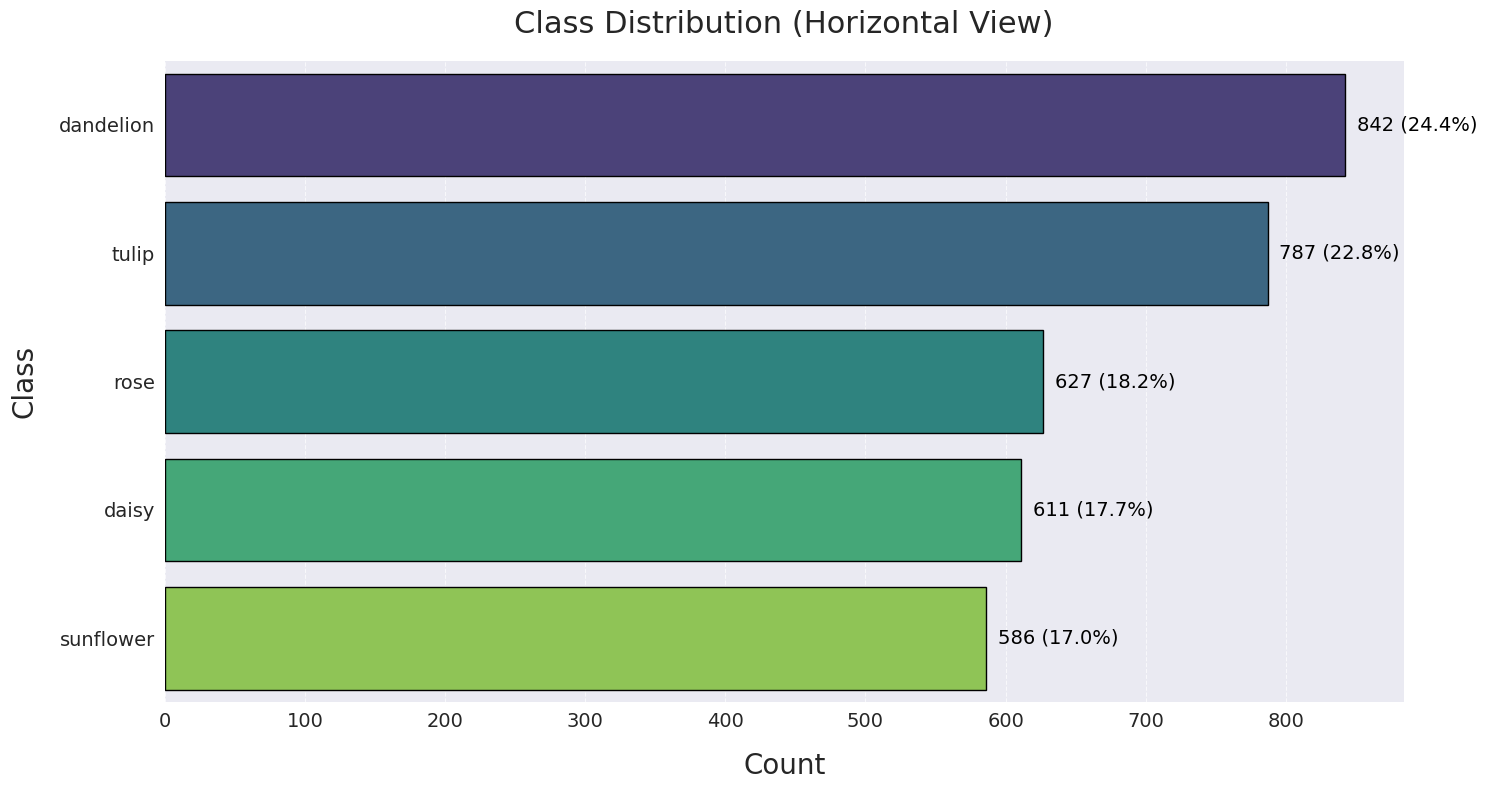

In [14]:
# Plot to analyze total count of different images present in the dataset

sns.set_style("darkgrid")

class_counts = train_df['labels'].value_counts()
plt.figure(figsize=(15, 8))
ax = sns.barplot(
    y=class_counts.index,
    x=class_counts.values,
    palette='viridis',
    edgecolor='black',
    orient='h'
)

ax.set_ylabel("Class", fontsize=20, labelpad=15)
ax.set_xlabel("Count", fontsize=20, labelpad=15)
plt.title('Class Distribution (Horizontal View)', fontsize=22, pad=20)

for i, value in enumerate(class_counts.values):
    percentage = f"{(value / class_counts.sum() * 100):.1f}%"
    ax.text(value + max(class_counts.values) * 0.01, i, f"{value} ({percentage})",
            va='center', fontsize=14, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

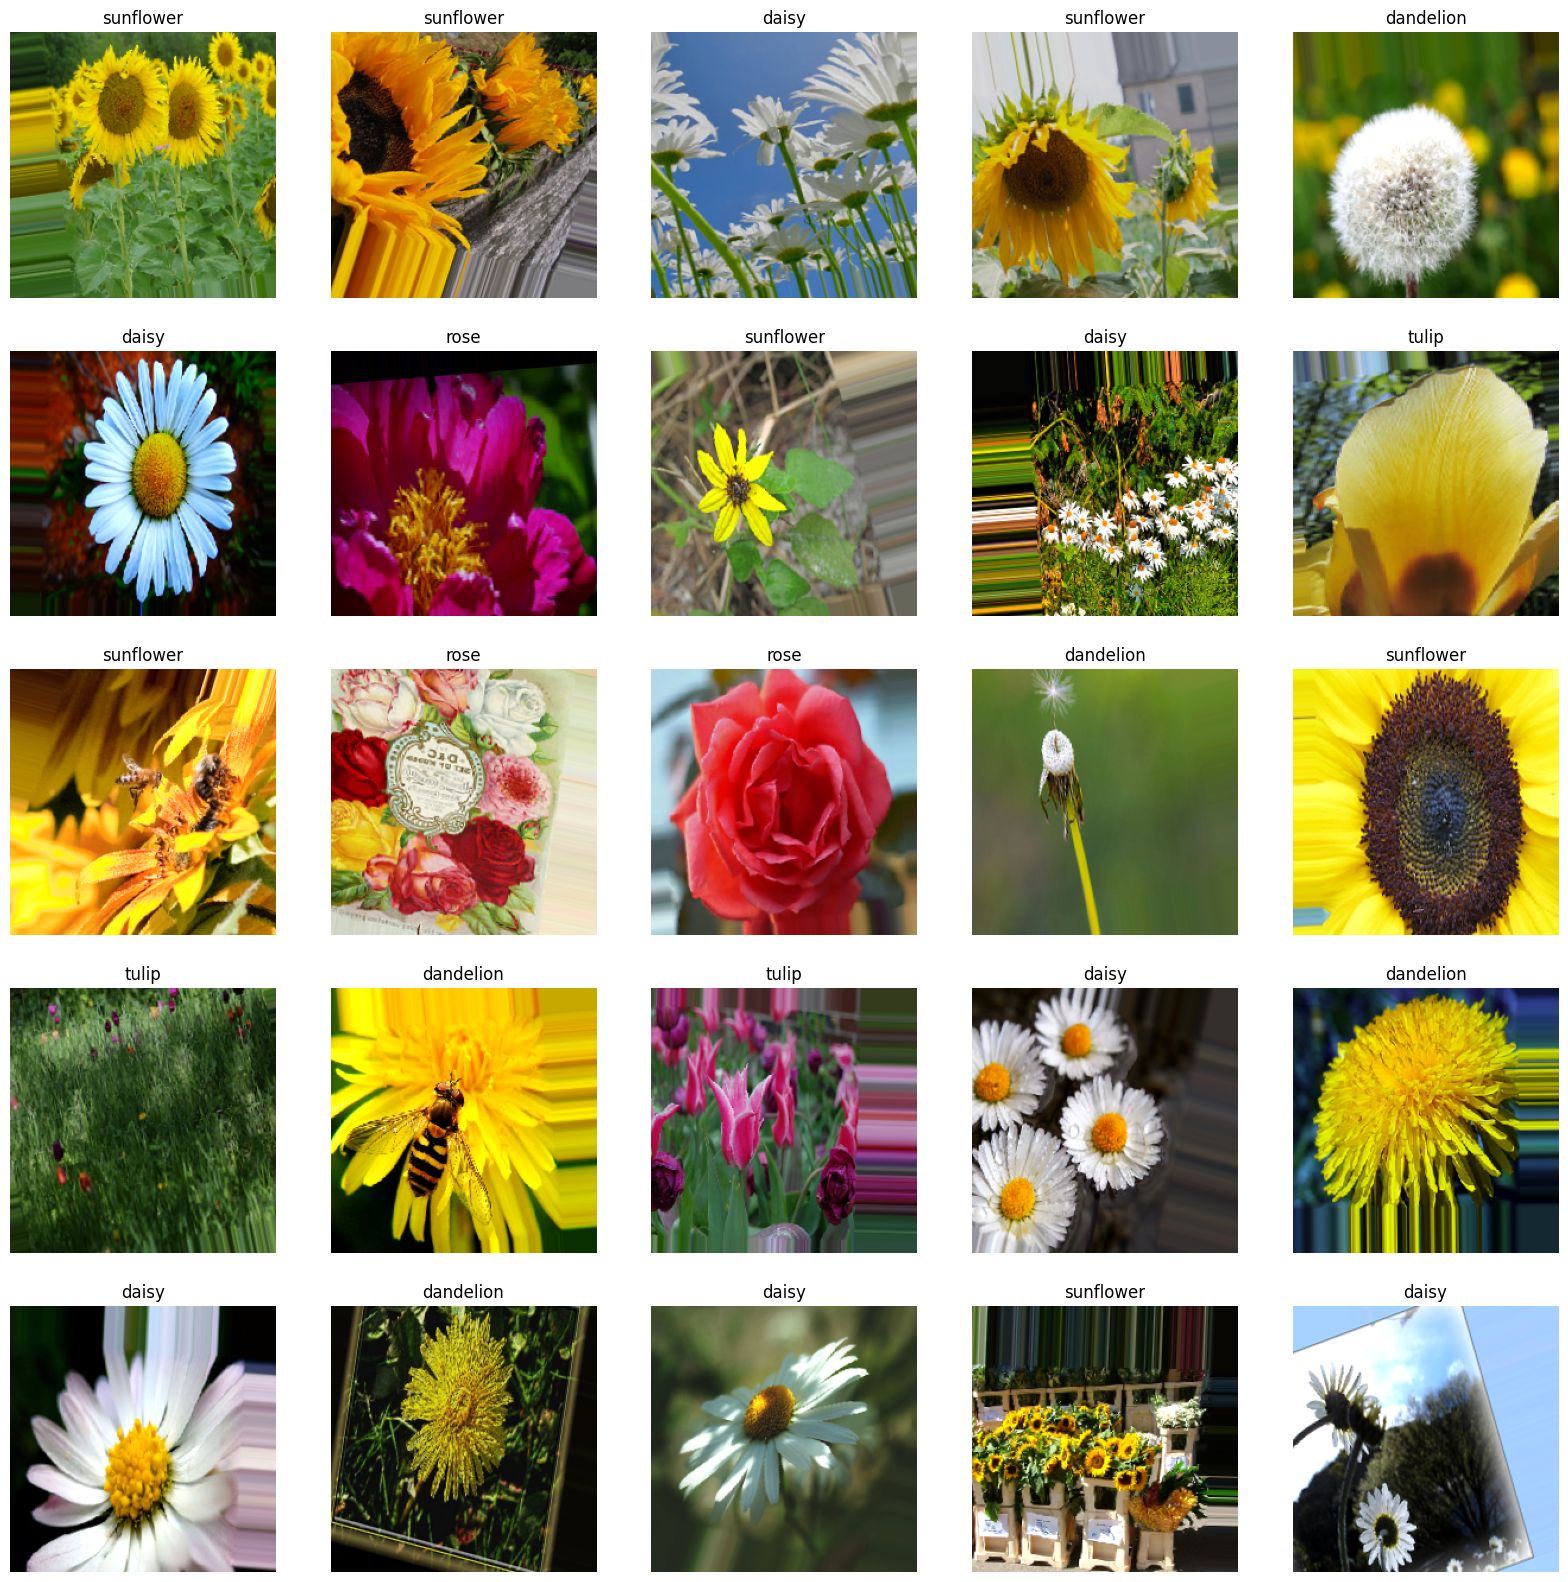

In [15]:

# Plotting sample images from the dataset

def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'black', fontsize= 12)
        plt.axis('off')
    plt.show()
     

show_images(train_gen)


## Model Building

### EfficientNetB3

In [35]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

In [36]:
model = Sequential([

    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')

])

In [37]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,199,924 (42.72 MB)

 Trainable params: 413,317 (1.58 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 67s 457ms/step - accuracy: 0.6198 - loss: 1.0686 - val_accuracy: 0.8819 - val_loss: 0.3357
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.7949 - loss: 0.5587 - val_accuracy: 0.8912 - val_loss: 0.2797
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.8251 - loss: 0.4860 - val_accuracy: 0.8912 - val_loss: 0.2726
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8605 - loss: 0.3957 - val_accuracy: 0.8889 - val_loss: 0.2700
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8555 - loss: 0.3902 - val_accuracy: 0.8935 - val_loss: 0.2855
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.8744 - loss: 0.3638 - val_accuracy: 0.8958 - val_loss: 0.2823
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.8690 - loss: 0.3840 - val_accuracy: 0.9074 - val_loss: 0.2657
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8907 - loss: 0

In [41]:
history_df = pd.DataFrame(history.history)

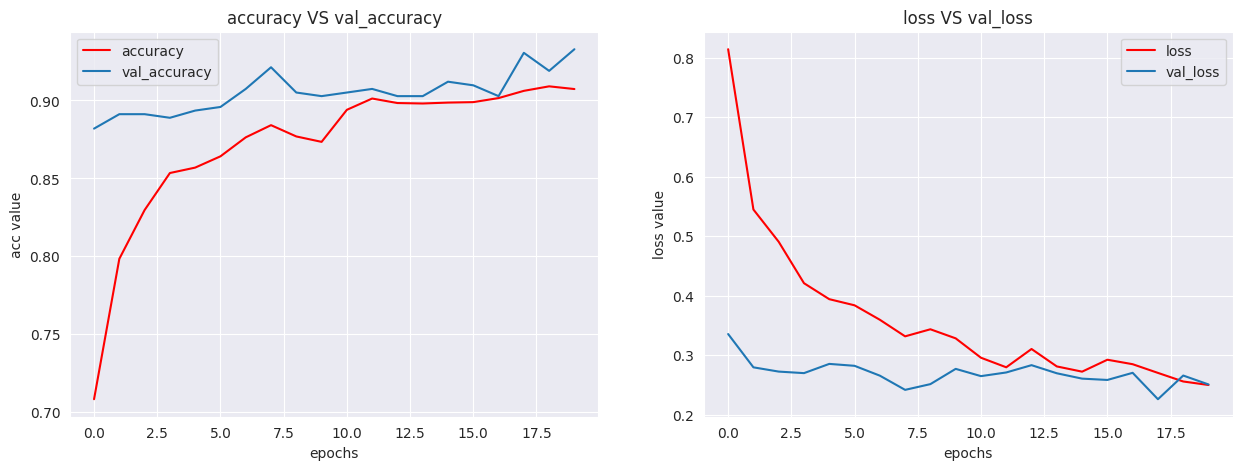

In [69]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

### VGG16

In [63]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

In [64]:
model = Sequential([

    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')

])

In [65]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,864,837 (56.70 MB)

 Trainable params: 149,125 (582.52 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [68]:
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 49s 354ms/step - accuracy: 0.4682 - loss: 1.3367 - val_accuracy: 0.7593 - val_loss: 0.6523
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.7451 - loss: 0.6959 - val_accuracy: 0.8264 - val_loss: 0.4547
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.7877 - loss: 0.5980 - val_accuracy: 0.8472 - val_loss: 0.4371
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.7822 - loss: 0.5742 - val_accuracy: 0.8449 - val_loss: 0.4270
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.8143 - loss: 0.5205 - val_accuracy: 0.8449 - val_loss: 0.4330
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.8180 - loss: 0.4902 - val_accuracy: 0.8519 - val_loss: 0.4126
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.8171 - loss: 0.4936 - val_accuracy: 0.8380 - val_loss: 0.4196
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - accuracy: 0.8143 - loss: 0

In [70]:
history_df = pd.DataFrame(history.history)

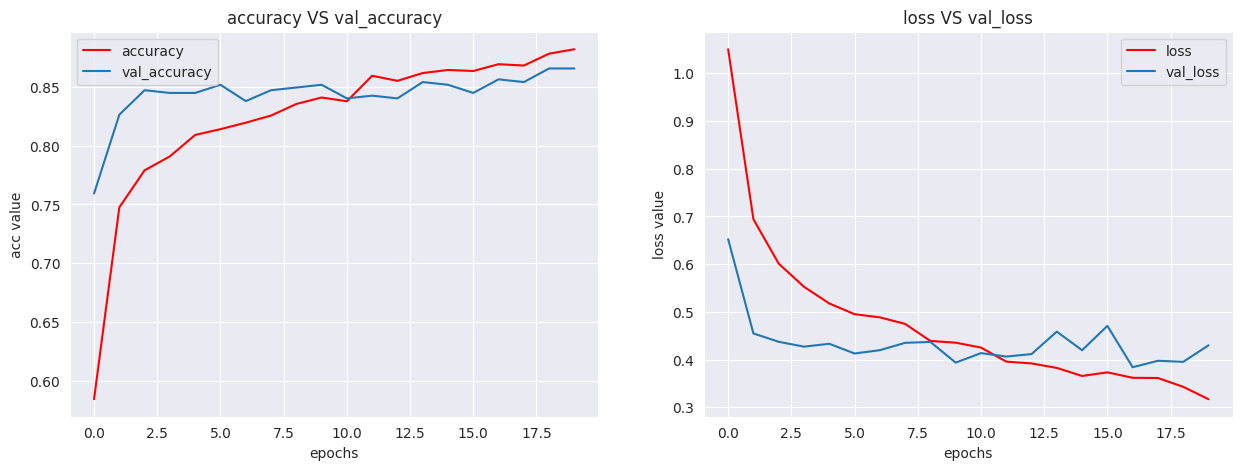

In [71]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()